# **Environment Setup**
Install required dependencies:

In [19]:
!pip install ftfy regex tqdm -q
!pip install git+https://github.com/openai/CLIP.git -q
!pip install faiss-cpu pillow numpy matplotlib -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 88.3 MB/s eta 0:00:00


# **Imports**

Libraries for CLIP inference, FAISS indexing, and visualization.

In [20]:
import os
import numpy as np
import faiss
import torch
import clip
from PIL import Image
import matplotlib.pyplot as plt

## **Model Initialization**


Loads the CLIP ViT-B/32 model and selects GPU if available.

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 70.4MiB/s]


##**Dataset Download**

The Flickr8k dataset is downloaded directly from Kaggle using `kagglehub` and stored in the local runtime for further processing.

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'flickr8k' dataset.
Path to dataset files: /kaggle/input/flickr8k


## **Dataset Verification**

Lists the available input directories and confirms that the Flickr8k dataset is accessible in the Kaggle environment.

In [34]:
import os
os.listdir("/kaggle/input/")
os.listdir("/kaggle/input/flickr8k")

['captions.txt', 'Images']

## **Image Loading**

Sets the image directory, loads all `.jpg` files from the dataset, and verifies the total number of images available for processing.

In [14]:
IMAGE_DIR = "/kaggle/input/flickr8k/Images"

image_files = sorted([
    f for f in os.listdir(IMAGE_DIR)
    if f.lower().endswith(".jpg")
])

print(f"Images found: {len(image_files)}")
image_files[:5]

Images found: 8091


['1000268201_693b08cb0e.jpg',
 '1001773457_577c3a7d70.jpg',
 '1002674143_1b742ab4b8.jpg',
 '1003163366_44323f5815.jpg',
 '1007129816_e794419615.jpg']

## **Image Embedding**

Encodes an input image into a fixed-length feature vector using the CLIP image encoder. The image is preprocessed, passed through the model, and returned as a normalized NumPy array for indexing and retrieval.

In [15]:
def embed_image(image_path):
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model.encode_image(image)
    return embedding.cpu().numpy().astype("float32")

## **Text Embedding**

Converts an input text query into a fixed-length feature vector using the CLIP text encoder. The embedding is used for similarity comparison with image features in the shared embedding space.

In [16]:
def embed_text(text):
    text_tokens = clip.tokenize([text]).to(device)
    with torch.no_grad():
        embedding = model.encode_text(text_tokens)
    return embedding.cpu().numpy().astype("float32")

## **Image Embedding Generation**

Generates feature vectors for all images in the dataset using the CLIP image encoder and stores them in a matrix for efficient similarity search.

In [22]:
image_embeddings = []
image_paths = []

for img in image_files:
    path = os.path.join(IMAGE_DIR, img)
    emb = embed_image(path)

    image_embeddings.append(emb)
    image_paths.append(path)

image_embeddings = np.vstack(image_embeddings)

print("Embedding shape:", image_embeddings.shape)

Embedding shape: (8091, 512)


## **Embedding Normalization**

Applies L2 normalization to all image embeddings to enable cosine similarity–based comparison during retrieval.

In [23]:
faiss.normalize_L2(image_embeddings)

## Similarity Search with FAISS

Creates a FAISS index using inner-product similarity, adds the normalized image embeddings, and retrieves the top-k most similar images for a given text query using CLIP text embeddings.

In [24]:
embedding_dim = image_embeddings.shape[1]

index = faiss.IndexFlatIP(embedding_dim)
index.add(image_embeddings)

print("Total indexed images:", index.ntotal)

Total indexed images: 8091


## **Text Query and Retrieval**

Encodes the input text query using CLIP, performs similarity search on the FAISS index, and returns the top-k most relevant images along with their similarity scores.

In [42]:
query = query = "A surfer riding a big ocean wave"

query_embedding = embed_text(query)
faiss.normalize_L2(query_embedding)

k = 10
scores, indices = index.search(query_embedding, k)

results = [
    (image_paths[i], scores[0][rank])
    for rank, i in enumerate(indices[0])
]

results

[('/kaggle/input/flickr8k/Images/3085667865_fa001816be.jpg',
  np.float32(0.30626446)),
 ('/kaggle/input/flickr8k/Images/3085667767_66041b202e.jpg',
  np.float32(0.30389494)),
 ('/kaggle/input/flickr8k/Images/3093971101_543237971d.jpg',
  np.float32(0.30319196)),
 ('/kaggle/input/flickr8k/Images/2842439618_fb20fe2215.jpg',
  np.float32(0.2986628)),
 ('/kaggle/input/flickr8k/Images/1308617539_54e1a3dfbe.jpg',
  np.float32(0.29334056)),
 ('/kaggle/input/flickr8k/Images/3044536048_e615466e7f.jpg',
  np.float32(0.29148895)),
 ('/kaggle/input/flickr8k/Images/3116011063_f4071ccce6.jpg',
  np.float32(0.29073882)),
 ('/kaggle/input/flickr8k/Images/3341782693_426bf7139b.jpg',
  np.float32(0.29048368)),
 ('/kaggle/input/flickr8k/Images/3638459638_ec74e3ff89.jpg',
  np.float32(0.28973532)),
 ('/kaggle/input/flickr8k/Images/3413571342_b9855795e2.jpg',
  np.float32(0.28962106))]

## Result Visualization

Displays the top-k retrieved images along with their similarity scores for qualitative evaluation of the retrieval performance.

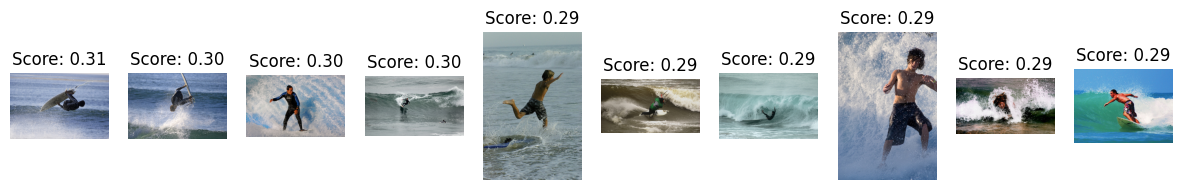

In [43]:
plt.figure(figsize=(15, 4))

for i, (path, score) in enumerate(results):
    img = Image.open(path)
    plt.subplot(1, k, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Score: {score:.2f}")

plt.show()

## Image Query and Retrieval

Encodes a query image using the CLIP image encoder, performs similarity search on the FAISS index, and retrieves the top-k most visually similar images from the dataset.

In [39]:
query_image = "/kaggle/input/flickr8k/Images/2546667441_bbe87a6285.jpg"

query_emb = embed_image(query_image)
faiss.normalize_L2(query_emb)

scores, indices = index.search(query_emb, k)

img_results = [
    (image_paths[i], scores[0][rank])
    for rank, i in enumerate(indices[0])
]

img_results

[('/kaggle/input/flickr8k/Images/2546667441_bbe87a6285.jpg',
  np.float32(0.9999998)),
 ('/kaggle/input/flickr8k/Images/3524436870_7670df68e8.jpg',
  np.float32(0.8896587)),
 ('/kaggle/input/flickr8k/Images/2519594430_551225e5bd.jpg',
  np.float32(0.8882377)),
 ('/kaggle/input/flickr8k/Images/472860064_a96a228796.jpg',
  np.float32(0.8876978)),
 ('/kaggle/input/flickr8k/Images/2561481438_447b852e4d.jpg',
  np.float32(0.87084043)),
 ('/kaggle/input/flickr8k/Images/2222498879_9e82a100ab.jpg',
  np.float32(0.8634727)),
 ('/kaggle/input/flickr8k/Images/476760133_c33d2bd83d.jpg',
  np.float32(0.8634256)),
 ('/kaggle/input/flickr8k/Images/2095444126_201ff9f222.jpg',
  np.float32(0.8594878)),
 ('/kaggle/input/flickr8k/Images/245252561_4f20f1c89e.jpg',
  np.float32(0.8541105)),
 ('/kaggle/input/flickr8k/Images/1164131282_b30926f332.jpg',
  np.float32(0.8514826))]